In [2]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24.csv'
df = pd.read_csv(file_path)
# df

In [3]:
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we..."
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss..."
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...
...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Localities,Rovaniemi,did not prevent our table from stealing. Its a...


In [16]:
# Dictionary for contractions
contraction_dict = {
    "it's": "it is", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "I'd": "I would", "I'll": "I will", "I'm": "I am", "I've": "I have",
    "isn't": "is not", "it's": "it is", "let's": "let us", "might've": "might have",
    "must've": "must have", "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "we'd": "we would", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "where's": "where is", "who'd": "who would",
    "who'll": "who will", "who's": "who is", "who've": "who have", "won't": "will not",
    "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have",
    "it’s": "it is", "aren’t": "are not", "can’t": "cannot", "couldn’t": "could not",
    "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not",
    "hasn’t": "has not", "haven’t": "have not", "he’d": "he would", "he’ll": "he will",
    "he’s": "he is", "I’d": "I would", "I’ll": "I will", "I’m": "I am", "I’ve": "I have",
    "isn’t": "is not", "it’s": "it is", "let’s": "let us", "might’ve": "might have",
    "must’ve": "must have", "mustn’t": "must not", "shan’t": "shall not", "she’d": "she would",
    "she’ll": "she will", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not",
    "that’s": "that is", "there’s": "there is", "they’d": "they would", "they’ll": "they will",
    "they’re": "they are", "they’ve": "they have", "we’d": "we would", "we’re": "we are",
    "we’ve": "we have", "weren’t": "were not", "what’ll": "what will", "what’re": "what are",
    "what’s": "what is", "what’ve": "what have", "where’s": "where is", "who’d": "who would",
    "who’ll": "who will", "who’s": "who is", "who’ve": "who have", "won’t": "will not",
    "wouldn’t": "would not", "you’d": "you would", "you’ll": "you will", "you’re": "you are",
    "you’ve": "you have"
}

def preprocess_text(text):
    if pd.isna(text):
        return text
    
    if not isinstance(text, str):
        text = str(text)
        
    # HTML character conversions
    html_char_map = {
        "&amp;": "&",
        "&apos;": "'",
        "&#39;": "'",
        "â€™": "'",
    }
    for html_char, replacement in html_char_map.items():
        text = text.replace(html_char, replacement)

    # Regex to match:
    # 1. Any possible email address format
    # 2. URLs starting with http/https and ending with .com or .fi (with optional spaces)
    # 3. Any string that includes a slash (assumed to be a path or URL)
    # 4. Domain-like strings that end with .com or .fi, including spaces before the extensions
    patterns = [
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\b',  # Email addresses, more inclusive to capture 'username@hostname'
        r'https?://[^ ]*\.(com|fi)\b',             # Full URLs
        r'\b[^ ]+/[^ ]+\b',                        # Paths with slashes
        r'\b[^ ]*\.\s*(com|fi)\b'                  # Domains with optional spaces
    ]
    combined_pattern = r'|'.join(patterns)         # Combine all patterns
    text = re.sub(combined_pattern, '', text)      # Remove matches of the combined pattern
    text = text.lower()                            # Convert to lowercase
    words = text.split()                           # Split text into words
    text = " ".join([contraction_dict.get(word, word) for word in words]) # Replace contractions
    # text = re.sub(r'\b\w*(-\w*)+\b', '', text)     # Remove sequences of hyphenated words
    text = re.sub(r'â\w*', '', text)               # Remove codes starting with 'â'
    text = re.sub(r'&[^;\s]*', '', text)           # Remove HTML entities
    text = re.sub(r'\s+', ' ', text).strip()       # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)        # Remove non-letter characters

    return text

tqdm.pandas(desc="Processing")

df['title_processed'] = df['title'].progress_apply(preprocess_text)
df['thread_text_processed'] = df['thread_text'].progress_apply(preprocess_text)
df['combined_processed'] = df[['title_processed', 'thread_text_processed']].progress_apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df.loc[df['msg_type'] == 'thread_start', 'thread_text_processed'] = df.loc[df['msg_type'] == 'thread_start'].progress_apply(
    lambda x: ' '.join([str(x['title_processed']), str(x['thread_text_processed'])]).strip(), axis=1)
df.dropna(subset=['thread_text_processed'], inplace=True)
# df.to_csv('suomi24_bertweet_processed.csv', index=False)

df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24-processed.csv', index=False)

Processing:   0%|          | 0/218001 [00:00<?, ?it/s]

Processing: 100%|██████████| 7986/7986 [00:00<00:00, 101710.20it/s]


In [10]:
# df = df.drop(['title_processed', 'thread_text_processed', 'combined_processed',	'thread_text_hypothesis', 'combined_hypothesis', 'compound', 'sentiment'], axis=1)
# df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24.csv', index=False)

In [23]:
df[df['msg_type']=='thread_start']

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,title_processed,thread_text_processed,combined_processed
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",,but despised and questioned yes well we thoug...,but despised and questioned yes well we thou...
27,thread_start,3/16/2016 22:40,- I don't know. - What's the payoff?,14185813,0,Hobbies,Electronics,or melto iron case around the card? in the cas...,i do not know what is the payoff,i do not know what is the payoff or melto iro...,i do not know what is the payoff or melto ir...
67,thread_start,7/18/2005 12:31,"- Oh, my God! - Oh, my God!",1924962,0,Entertainment and culture,Domestic Celebrity Gossips,Then all the world's pingers and so on. Sais V...,oh my god oh my god,oh my god oh my god then all the worlds pinge...,oh my god oh my god then all the worlds ping...
79,thread_start,2/6/2012 11:41,- That's what I'm talking about. - That's outr...,10436440,0,Localities,General information about North Karelia,"fuses. Sell stuff forward, follows the place a...",that is what im talking about that is outrag...,that is what im talking about that is outrage...,that is what im talking about that is outrag...
97,thread_start,8/24/2005 12:17,- Yeah. - Do you think they're choir celebrities?,2025891,0,Localities,Kuopio,thank you. So tell me soon that has the dimple...,yeah do you think they are choir celebrities,yeah do you think they are choir celebrities ...,yeah do you think they are choir celebrities...
...,...,...,...,...,...,...,...,...,...,...,...
217848,thread_start,2/20/2014 22:52,zuumi,12074159,0,Science and technology,General information on photography,Here's a fixture with threads and an external ...,zuumi,zuumi heres a fixture with threads and an exte...,zuumi heres a fixture with threads and an exte...
217853,thread_start,4/16/2014 10:19,Localities,12189003,0,Localities,Riihimki,If there are 5 types of people in the whole to...,localities,localities if there are types of people in th...,localities if there are types of people in th...
217903,thread_start,3/15/2013 10:53,Localities,11340784,0,Localities,Nickel,it would be a good place for the webcam. Other...,localities,localities it would be a good place for the we...,localities it would be a good place for the we...
217910,thread_start,8/3/2013 14:21,Science and technology,11631088,0,Science and technology,Digital cameras,"which camera, digital mind or good diggari. I ...",science and technology,science and technology which camera digital mi...,science and technology which camera digital mi...


In [3]:
column = 'thread_text_processed'

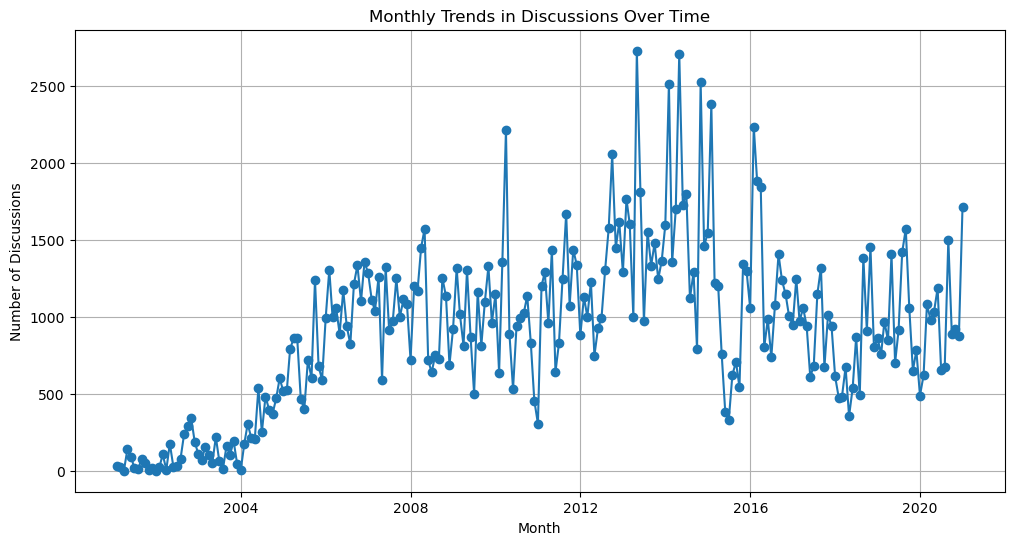

In [6]:
# Convert 'datetime' column to datetime type for easier manipulation
df['datetime'] = pd.to_datetime(df['datetime'])

# Group data by month and count occurrences
monthly_trends = df.set_index('datetime').resample('M').count()[column]

# Plotting the trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends.index, monthly_trends.values, marker='o', linestyle='-')
plt.title('Monthly Trends in Discussions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Discussions')
plt.grid(True)
plt.show()


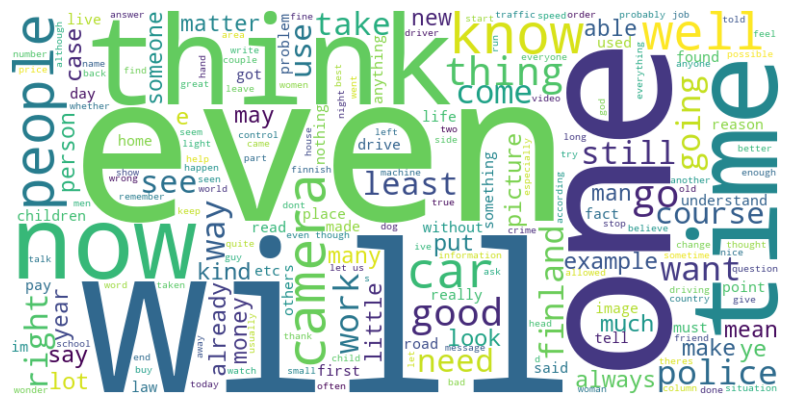

In [30]:
# Generate a word cloud for the most common words in discussions
text = ' '.join(df[column].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


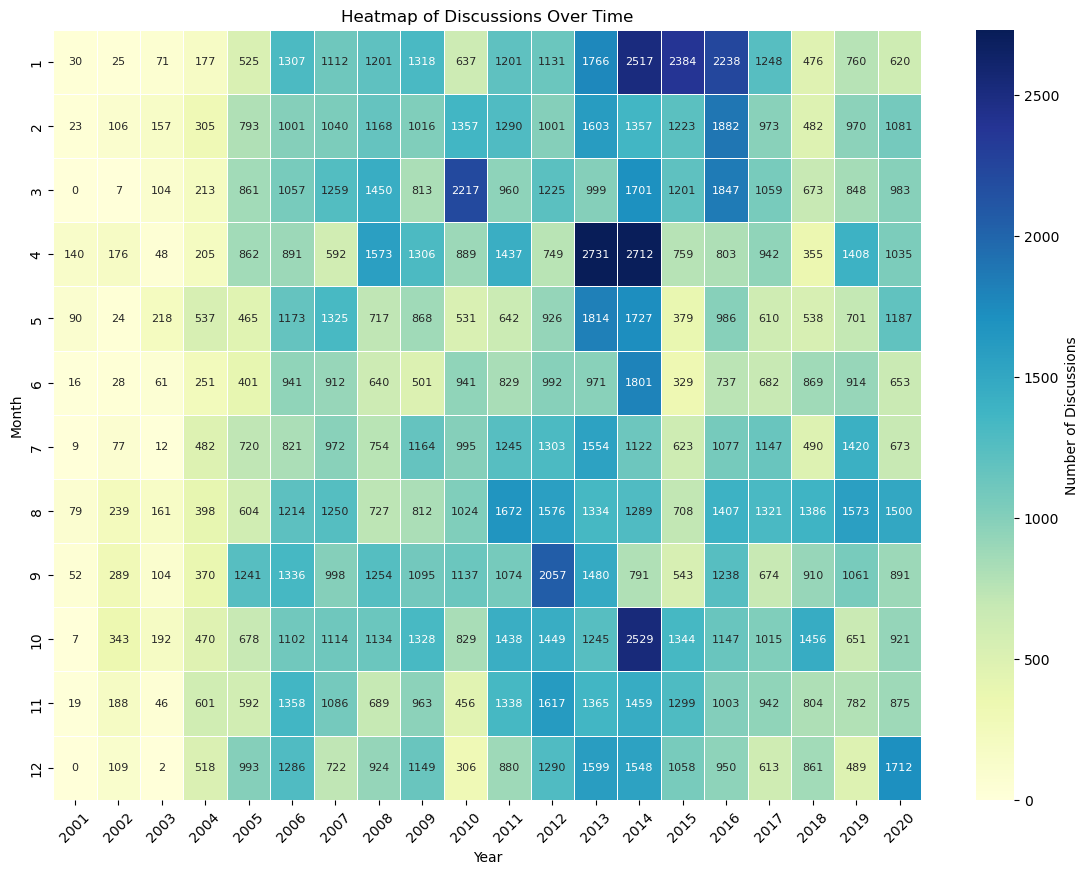

In [10]:
# Extract year and month
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month

# Group data by year and month and count occurrences
yearly_monthly_trends = df.groupby(['year', 'month']).count()[column]

# Ensure the index includes all years and months up to 2020
full_index = pd.MultiIndex.from_product([range(2001, 2021), range(1, 13)], names=['year', 'month'])
yearly_monthly_trends = yearly_monthly_trends.reindex(full_index, fill_value=0)

# Convert to a DataFrame and reset the index
yearly_monthly_trends_df = yearly_monthly_trends.reset_index()

# Pivot the DataFrame
heatmap_data = yearly_monthly_trends_df.pivot_table(index='month', columns='year', values=column, fill_value=0)

# Display the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f", annot_kws={"size": 8}, linewidths=.5, cbar_kws={'label': 'Number of Discussions'})
plt.title('Heatmap of Discussions Over Time')
plt.xlabel('Year')
plt.ylabel('Month')
plt.xticks(rotation=45)
plt.show()

In [34]:
# Define keywords related to privacy, security, and personal experiences
keywords = ['privacy', 'data breach', 'trust', 'saw', 'found', 'sight', 'record' 'recorded', 'safety', 'security', 'crime', 'protection', 'encounter', 'experience', 'benefit', 'drawback', 'camera', 'public', 'cctv', 'surveillance', 'concern', 'protect', 'monitoring', 'footage', 'personal', 'cameras', 'concerns', 'monitor']

# Count the frequency of each keyword in the processed text
keyword_counts = df[column].str.split(expand=True).stack().value_counts()
keyword_counts = keyword_counts[keyword_counts.index.isin(keywords)]

# Plot the keyword frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x=keyword_counts.values, y=keyword_counts.index, palette='viridis')
plt.title('Keyword Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.show()


MemoryError: Unable to allocate 417. MiB for an array with shape (54718251,) and data type object

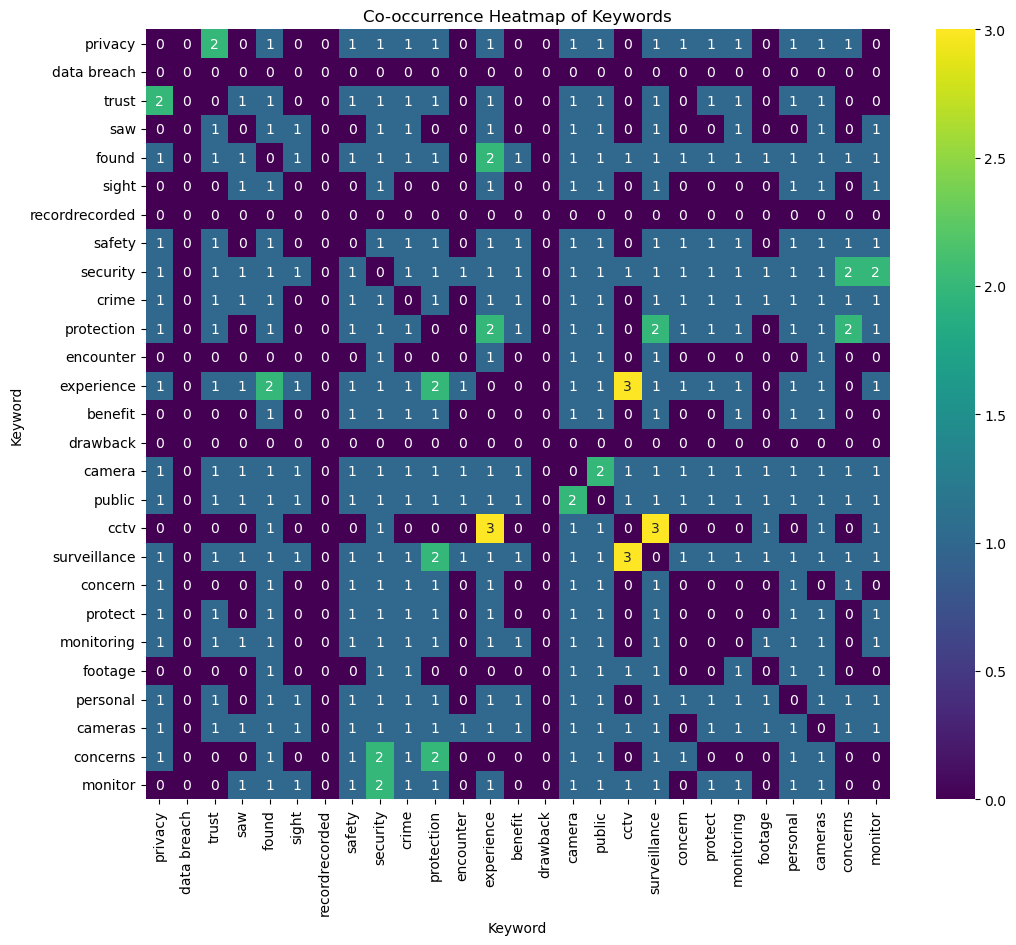

In [35]:
# Function to find co-occurrences
def find_cooccurrences(text, keywords):
    tokens = text.split()
    cooccurrences = defaultdict(int)
    for i, token in enumerate(tokens):
        if token in keywords:
            for j in range(max(0, i-5), min(len(tokens), i+6)):
                if tokens[j] != token and tokens[j] in keywords:
                    cooccurrences[(token, tokens[j])] += 1
    return cooccurrences

# Find co-occurrences in the dataset
cooccurrences = defaultdict(int)
for text in df[column]:
    cooccurrences.update(find_cooccurrences(text, keywords))

# Convert co-occurrences to a matrix
cooc_matrix = np.zeros((len(keywords), len(keywords)))
keyword_index = {keyword: idx for idx, keyword in enumerate(keywords)}

for (kw1, kw2), count in cooccurrences.items():
    i, j = keyword_index[kw1], keyword_index[kw2]
    cooc_matrix[i, j] = count
    cooc_matrix[j, i] = count

# Plot the co-occurrence heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cooc_matrix, xticklabels=keywords, yticklabels=keywords, cmap='viridis', annot=True, fmt='g')
plt.title('Co-occurrence Heatmap of Keywords')
plt.xlabel('Keyword')
plt.ylabel('Keyword')
plt.show()


In [5]:
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24-processed.csv'
df = pd.read_csv(file_path)
# df

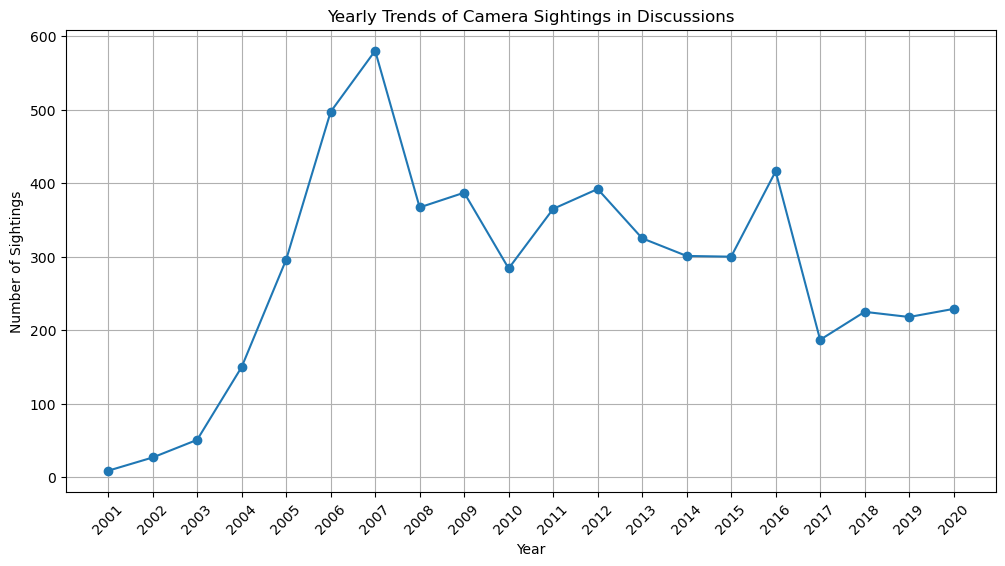

In [11]:
# Define keywords/phrases indicating a camera sighting
sighting_keywords = ['saw camera', 'camera saw', 'noticed camera', 'camera noticed', 'camera spotted', 'camera spot', 'camera sighted', 'camera sight', 'area camera', 'around camera', 'spotted camera', 'spot camera', 'sighted camera', 'sight camera', 'camera area', 'camera around', 'camera nearby', 'nearby camera', 'camera security', 'camera hidden', 'park camera', 'camera traffic', 'camera caught', 'camera recorded', 'camera filmed', 'footage camera', 'camera surveillance', 'surveillance camera', 'security camera', 'hidden camera', 'traffic camera', 'caught camera', 'recorded camera', 'filmed camera', 'camera footage', 'building camera', 'under camera surveillance', 'camera park', 'camera building', 'camera street', 'street camera', 'office camera', 'station camera', 'camera office', 'camera station']

# Create a boolean column for camera sightings
df['camera_sighting'] = df[column].apply(lambda x: any(phrase in x.lower() for phrase in sighting_keywords))
# print(sighting_data)

# Filter data to only include rows where a camera sighting is mentioned
sighting_data = df[df['camera_sighting']]

# Aggregate the sighting data by month
yearly_sightings = sighting_data.groupby(sighting_data['datetime'].dt.year).size().reset_index(name='num_sightings')

# Convert the datetime to string for plotting
yearly_sightings['datetime'] = yearly_sightings['datetime'].astype(str)

# Plot the yearly trends
plt.figure(figsize=(12, 6))
plt.plot(yearly_sightings['datetime'], yearly_sightings['num_sightings'], marker='o', linestyle='-')
plt.title('Yearly Trends of Camera Sightings in Discussions')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()